# Illustration of w-imaging

In [1]:
%matplotlib inline

import sys
sys.path.append('../..')

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = 16, 12


import numpy
import scipy
import scipy.special

from crocodile.clean import *
from crocodile.synthesis import *
from crocodile.simulate import *
from util.visualize import *
from arl.configuration import named_configuration

Generate baseline coordinates for an observation with the VLA over 6 hours, with a visibility recorded every 10 minutes. The phase center is fixed at a declination of 45 degrees. We assume that the imaged sky says at that position over the course of the observation.

Note how this gives rise to fairly large $w$-values.

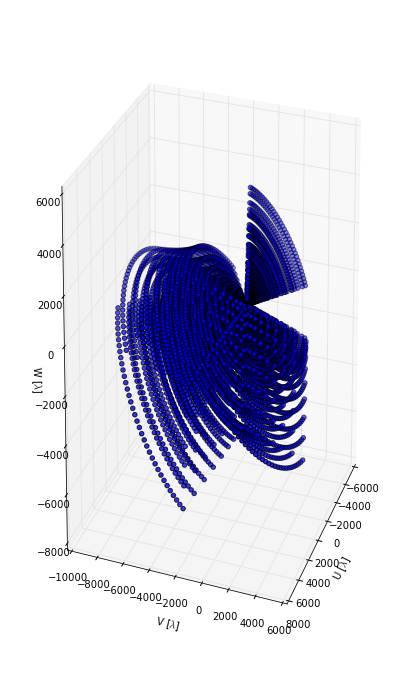

In [2]:
vlas = named_configuration('VLAA')
ha_range = numpy.arange(numpy.radians(0),
                        numpy.radians(90),
                        numpy.radians(90 / 36))
dec = numpy.radians(45)
vobs = xyz_to_baselines(vlas.data['xyz'], ha_range, dec)

# Wavelength: 5 metres 
wvl=5
uvw = vobs / wvl

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
ax = plt.figure().add_subplot(121, projection='3d')
ax.scatter(uvw[:,0], uvw[:,1], uvw[:,2])
ax.set_xlabel('U [$\lambda$]')
ax.set_ylabel('V [$\lambda$]')
ax.set_zlabel('W [$\lambda$]')
ax.view_init(20, 20)
pylab.show()

## We can now generate visibilities for these baselines by simulation. We place three sources.

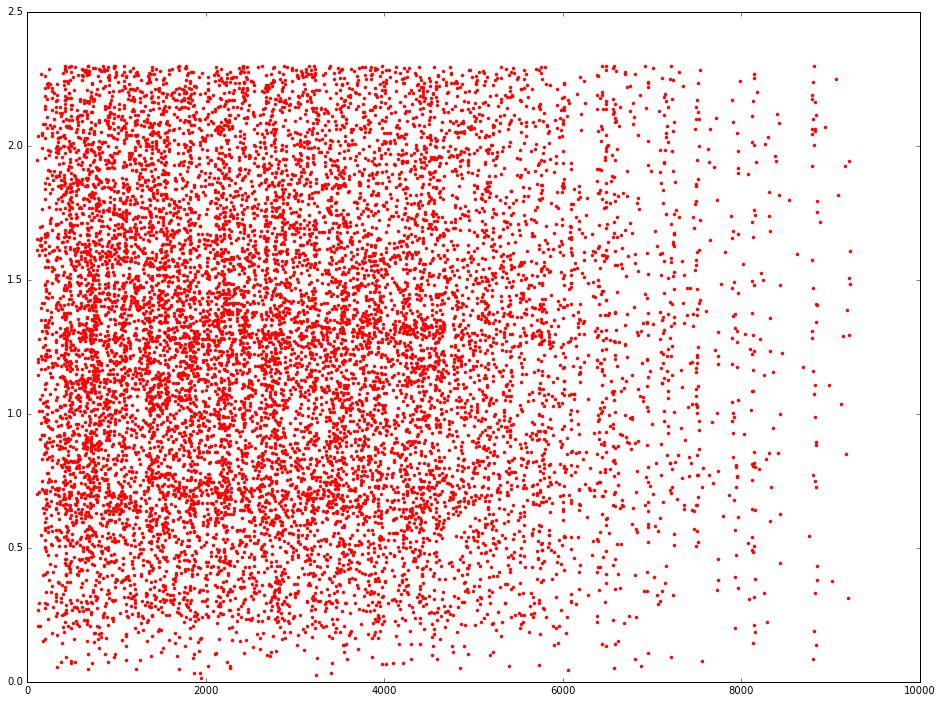

In [3]:
vis = 1.0*simulate_point(uvw, 0.000, 0.000)
vis += 0.5*simulate_point(uvw, 0.02, 0.03)
vis += 0.8*simulate_point(uvw, 0.04, 0.00)
plt.clf()
uvdist=numpy.sqrt(uvw[:,0]**2+uvw[:,1]**2)
plt.plot(uvdist, numpy.abs(vis), '.', color='r')

Using imaging, we can now reconstruct the image. The easiest option is to use simple imaging without a convolution function:

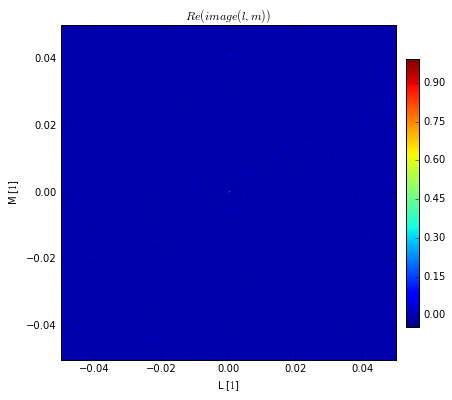

In [4]:
theta = 2*0.05
lam = 18000
d,p,_=doimg(theta, lam, uvw, vis, simpleimg)
show_image(d, "image", theta)

Zooming in shows the source structure in detail

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


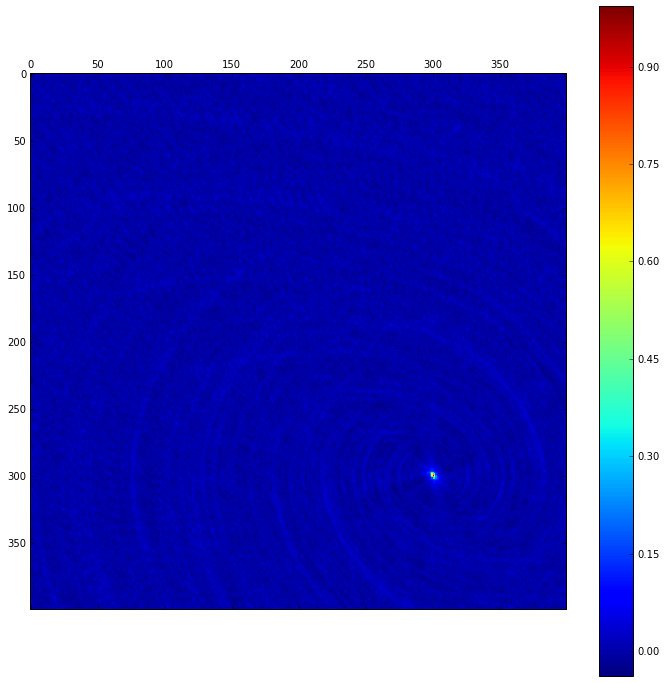

In [5]:
step=200
def zoom(x, y): pylab.matshow(d[y:y+2*step,x:x+2*step]) ; pylab.colorbar();  pylab.show()
from ipywidgets import interact
interact(zoom, x=(0,d.shape[0]-2*step,step), y=(0,d.shape[1]-2*step,step));

If we use convolution kernels for $w$-reprojection, we can increase source brightness. First we make a cache to hold the convolution kernels.

In [6]:
wstep=1000
wcachesize=int(numpy.ceil(numpy.abs(uvw[:,2]).max()/wstep))
print("Making w-kernel cache of %d kernels" % (wcachesize))
wcache=pylru.FunctionCacheManager(lambda iw: wkernaf(N=256, theta=theta, w=iw*wstep, s=15, Qpx=4), 100)
imgfn=lambda *x: wcacheimg(*x, wstep=wstep, wcache=wcache)

Making w-kernel cache of 7 kernels


In [ ]:
d,p,_=doimg(theta, lam, uvw, vis, imgfn)
show_image(d, "image", theta)

In [ ]:
step=200
interact(zoom, x=(0,d.shape[0]-2*step,step), y=(0,d.shape[1]-2*step,step))